<a href="https://colab.research.google.com/github/yanmingl/NaturalLanguageProcessing/blob/master/Transformers_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Copyright 2019 The TensorFlow Authors.

# Transformer Chatbot




## Import Packages

In [258]:
# Install tensorflow, load it, and set the random seed
# !pip install tensorflow==2.9.1
import tensorflow as tf
tf.keras.utils.set_random_seed(1234)

# import embedded dataset
# !pip install tensorflow-datasets==4.6.0
import tensorflow_datasets as tfds

# import other pacakages
import os
import re
import numpy as np
import matplotlib.pyplot as plt

## GPU /TPU initialization
On Google colab, select  `TPU` or `GPU` hardware accelerator

In [259]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU {}".format(tpu.cluster_spec().as_dict()["worker"]))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print(f"REPLICAS: {strategy.num_replicas_in_sync}")

REPLICAS: 1


### Hyperparameters

In [260]:
# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# Max length of a sentence whether for question or answer
MAX_LENGTH = 40

# For tf.data.Dataset
BATCH_SIZE = 64
BUFFER_SIZE = 20000 

# For transformer
NUM_LAYERS = 2
NUM_HEADS = 8
D_MODEL = 256
UNITS = 512
DROPOUT = 0.1

EPOCHES = 40

## Download Dataset
Cornell Movie-Dialogs Corpus
- more than 220 thousands conversational exchanges
- between more then 10k pairs of characters

**movie_conversation.txt** contains list of conversation IDs and **movie_lines.text** contains the  text associated with each conversation ID.



In [261]:
# Download dataset and define the file path
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract = True # download as an archive
)

path_to_dataset = os.path.join(os.path.dirname(path_to_zip), 'cornell movie-dialogs corpus')
path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset, 'movie_conversations.txt')

## Load and preprocess data
For simplificity and fastness, we limit the maximum number fo trainning samples to 25000, and the maximum length of the sentence to be 40.

We preprocess the dataset in the following orders:
- Extract `MAX_SAMPLES` conversation pairs into list of `question` and `answers`.
- Preprocess each sentence by removing special characters in each sentence.
- Build tokenizer(map text to ID and ID to text)
- Tokenize each sentence and add `START_TOKEN` and `END_TOKEN` to indicate the start and end of the sentence.
- Filter out sentence that has more than `MAX_LENGTH` tokens.
- Pad tokenized sentences to `MAX_LENGTH`.

### Extract question-answer pairs and remove the special characters in each sentence

In [262]:
def preprocess_sentence(sentence):
  '''preprocess sentence by strip, lowercase, add space between word and 
  punctation and remove contraction or replace other character with space'''
  # lowercase all words and remove the spaces at beginning and ending
  sentence = sentence.lower().strip()
  # put a space between a word and the punctuation following,
  # e.g. 'he is a boy.' --> 'he is a boy .'
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  # transform multi spaces into one space, '  ' --> ' '
  sentence = re.sub(r'[" "]+', " ", sentence)
  # removing contractions
  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r"he's", "he is", sentence)
  sentence = re.sub(r"she's", "she is", sentence)
  sentence = re.sub(r"it's", "it is", sentence)
  sentence = re.sub(r"that's", "that is", sentence)
  sentence = re.sub(r"what's", "that is", sentence)
  sentence = re.sub(r"where's", "where is", sentence)
  sentence = re.sub(r"how's", "how is", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "cannot", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"n'", "ng", sentence)
  sentence = re.sub(r"'bout", "about", sentence)
  # replace everthing with space except (a-z, A-Z, '.?!,')
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

  # remove the space at the begining and ending again
  sentence = sentence.strip()
  return sentence


def load_conversations():
  '''get questions and answers list by refering the conversation id in the 
  movie_conversations.txt and its text in the movie_lines.txt'''
  # dictionary of line to text
  id2line = {}
  # return a list of lines
  # e.g. ['Hello!\n', 'This file is for testing purposes.\n', 'Good Luck!']
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  # get line ID and text to id2line for each line
  # e.g. just one line
  # L900 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ As in…  --> {L900:AS in...}
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  # get the question and answer using the lineID in the movie_conversations.txt
  # and id2line, and put them into inputs and outputs respectively
  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  # e.g. u0 +++$+++ u2 +++$+++ m0 +++$+++ [‘L198’, ‘L199’]
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    # to get 'L198', 'L199'
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    # The former is the inputs, the latter is the outputs. > PUZZLE
    for i in range(len(conversation)-1):
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i+1]]))
      # slect question-answer pairs with MAX_SAMPLE size
      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs

questions, answers = load_conversations()

In [263]:
print(f'sample quesiton: {questions[20]}')
print(f'sample answer: {answers[20]}')

sample quesiton: i really , really , really wanna go , but i cannot . not unless my sister goes .
sample answer: i am working on it . but she does not seem to be going for him .


### Build Tokenizer

In [264]:
# Build tokenizer from corpus
# input the list of question and answer strings, also the vocab size, encoding to [1, ... vocab_size)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size = 2**13  # approximate size of target vocabulary, 8192
)

In [265]:
print(f'Tokenized sample question {tokenizer.encode(questions[20])}')

Tokenized sample question [4, 271, 3, 271, 3, 141, 385, 173, 3, 40, 4, 611, 2, 11, 864, 30, 2021, 3086, 1]


In [266]:
# Size of the vocabulary. Decode produces ints [1, vocab_size).
tokenizer.vocab_size  

8277

### Tokenize, filter and pad sentences

In [267]:
# Define START_TOKEN and END_TOKEN
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

def tokenize_and_filter(inputs, outputs):
  '''Tokenize, filter, and pad the sentence.'''
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize the sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen = MAX_LENGTH, padding='post'
  )
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post'
  )

  return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers) 

In [268]:
# Define VOCAD_SIZE for padded sentences
VOCAB_SIZE = tokenizer.vocab_size + 2  # for start and end token

print(f"Vocab size: {VOCAB_SIZE}")
print(f"Number of samples: {len(questions)}")

print(questions)

Vocab size: 8279
Number of samples: 44131
[[8277   58   22 ...    1 8278    0]
 [8277   69    3 ...    0    0    0]
 [8277   11    6 ...    0    0    0]
 ...
 [8277  201    2 ...    0    0    0]
 [8277    4  280 ...    0    0    0]
 [8277   76    3 ...    0    0    0]]


### Create `tf.data.DataSet`
We use `tf.data.DataSet`API to construct our data input pipline to utilize features like caching and prefetching to speed the training proprocess.

The transformer is an auto-regressive model (predict future values based on past values). It makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this examples uses teacher-forcing. Teacher forcing is passing the true output to next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to at the previous words in the input sequences to better predict the next word.

To prevent the model from peaking at the expected output, the model uses a look-ahead mask. This means, when we want to get the third predicted word, we just use the first two words; get the fourth, then use the first three; look-ahead mask will take care of this.

Target is divided into `dec_inputs` which padded as an input to the docoder and `outputs` for calculating our loss and accuracy.

In [269]:
# decode_inputs: START_TOKEN + question + [END_TOKEN + PAD_0 | ''], padding mask 
# outputs: question + END_TOKEN, look_ahead_mask
dataset = tf.data.Dataset.from_tensor_slices(
  (
      {'inputs': questions, 'dec_inputs': questions[:, :-1]},
      {'outputs': answers[:, 1:]}
  )
)

# Add dataset to cache
dataset = dataset.cache()
# Shuffle dataset for better training accuracy
dataset = dataset.shuffle(BUFFER_SIZE)
# Get batches of the dataset
dataset = dataset.batch(BATCH_SIZE)
# Prefetch next batch during the trainning of this batch to accelerate
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [270]:
print(dataset)

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


## Transformer


### Attention

#### Scaled dot product attention

The scaled dot-product attention function used by the transformer takes three inputs: Q(query), K(key), V(value). The equation used to calculate the attention weights is: `attention(Q, K, V) = softmax(QK^T/sqrt(d_k))V`

As the softmax normalization is done on the `key`, its values decides the amount
of importance given to the `query`.

The output represents the multiplication of the attention weights and the `value` vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flused out. 

The dot-product attention is scaled by a factor of square root of the depth. This is done for large values of depth, the dot product grows magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.

For example, 


In [271]:
def scaled_dot_product_attention(query, key, value, mask):
  '''get attention cofficients for values/words, suppose
  :data, [2,4]
  :query, key, value, [2, 3] 
  :matmul, [2, 2]
  :d_k, 3
  :mask, to solve the problem that padded value will account for the probability, see the code
  :attention_weights, [2,2]
  :output, [2,3]'''

  # QK^T
  matmul = tf.matmul(query, key, transpose_b=True)
  # (QK^T) / sqrt(d_k)
  d_k = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul / tf.math.sqrt(d_k)  # we call a vector logits followed by softmax operation
  # mask to zero out padding tokens
  if mask is not None:
    logits += mask * -1e9  # bca. we mark 1 if the padding tokens
  # softmax on the logits
  attention_weights = tf.nn.softmax(logits, axis=-1)
  # multiply V
  output = tf.matmul(attention_weights, value)
  return output

#### Multi-Head Attention

Multi-head attention consists of four parts:
- Linear layers and split into heads
- Scaled dot-product attention
- Concatenation of heads
- Final linear layer

Each multi-head attention block gets three inputs; Q(query), K(key), V(value). These are put through linear(Dense) layers and split up into multiple heads.

The `Scaled_dot_product_attention` defined to each head (broadcasted for efficiency). An appropriate mask must be used in the attetion app. The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, `query`, `key` and `value` are split into multi heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [272]:
# class MultiHeadAttentionLayer(tf.keras.layers.Layer):
#   def __init__(self, d_model, num_heads, **kwargs):
#     assert d_model % num_heads == 0
#     super(MultiHeadAttentionLayer, self).__init__(**kwargs)
#     self.num_heads = num_heads
#     self.d_model = d_model

#     self.depth = d_model // self.num_heads
    
#     self.query_dense = tf.keras.layers.Dense(units=d_model)
#     self.key_dense = tf.keras.layers.Dense(units=d_model)
#     self.value_dense = tf.keras.layers.Dense(units=d_model)

#     self.dense = tf.keras.layers.Dense(units=d_model)

#     def get_config(self):
#       config = super(MultiHeadAttentionLayer, self).get_config()
#       config.update(
#           {
#             'num_heads': self.num_heads,
#             'd_model': self.d_model,
#           }
#       )
#       return config
    
#     def split_heads(self, inputs, batch_size):
#       inputs = tf.keras.layers.Lambda(
#           inputs, shape=(batch_size, -1, self.num_heads, self.depth)
#       )(inputs)  #

#       return tf.keras.layers.Lambda(
#           lambda inputs: tf.transpose(inputs, perm=[0,2,1,3])
#       )(inputs)

#     def call(self, inputs):
#       query, key, value, mask = (
#           inputs['query'],
#           inputs['key'],
#           inputs['value'],
#           inputs['mask'],
#       )
#       batch_size = tf.shape(query)[0]

#       # linear layers
#       query = self.query_dense(query)
#       key = self.key_dense(key)
#       value = self.value_dense(value)

#       # split heads
#       query = self.split_heads(query, batch_size)
#       key = self.split_heads(key, batch_size)
#       value = self.split_heads(value, batch_size)

#       # scaled dot-product attention
#       scaled_attention = scaled_dot_product_attention(query, key, value, mask)
#       scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])(scaled_attention)

#       # concatenation of heads
#       concat_attention = tf.keras.layers.Lambda(
#           lambda scaled_attention: tf.reshape(
#               scaled_attention, (batch_size, -1, self.d_model)
#           )
#       )(scaled_attention)

#       # final linear layer
#       outputs = self.dense(concat_attention)
    
#       return outputs


In [273]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        assert d_model % num_heads == 0
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttentionLayer, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config

    def split_heads(self, inputs, batch_size):  ##
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)
        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
        )(inputs)

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads 
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

### Masking

In [274]:
def create_padding_mask(x):
  '''if pad token then mask as 1, otherwise 0'''
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence_length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [275]:
print(create_padding_mask(tf.constant([[1,2,0,3,0], [0,0,0,4,5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [276]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [277]:
print(create_look_ahead_mask(tf.constant([[1,20,0,4,5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)



### Positional encoding

In [278]:
# class PositionalEncoding(tf.keras.layers.Layer):
#   def __init__(self, position, d_model, **kwargs):
#      super(PositionalEncoding, self).__init__(**kwargs)
#      self.position = position
#      self.d_model = d_model
#      self.pos_encoding = self.positional_encoding(position, d_model)
  
#   def get_config(self):
#     config = super(PositionalEncoding, self).get_config()
#     config.update(
#         {
#             'position': self.position,
#             'd_model': self.d_model,
#         }
#     )
#     return config
  
#   def get_angles(self, position, i, d_model):
#     angles = 1 / tf.pow(10000, (2*(i//2)) / tf.cast(d_model, tf.float32))
#     return position * angles
  
#   def positional_encoding(self, position, d_model):
#     angle_rads = self.get_angles(
#         position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
#         i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
#         d_model = d_model,
#     )
#     # apply sin to the even index in the array
#     sines = tf.math.sin(angle_rads[:, 0::2])
#     # apply cos to the odd index in the array
#     cosines = tf.math.cos(angle_rads[:, 1::2])

#     pos_encoding = tf.concat([sines, cosines], axis=-1)
#     pos_encoding = pos_encoding[tf.newaxis, ...]  # 
#     return tf.cast(pos_encoding, tf.float32)

#   def call(self, inputs):
#     return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]   #

In [279]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

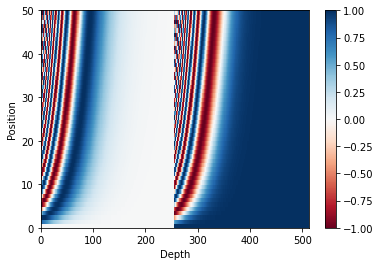

In [280]:
sample_pos_encoding = PositionalEncoding(50, 512, name="sample_pos_encoding")

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

### Encoder Layer

In [281]:
def encoder_layer(units, d_model, num_heads, dropout, name='encoder_layer'):
  inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
  padding_mask = tf.keras.Input(shape=(1,1,None), name='padding_mask')  #

  attention = MultiHeadAttentionLayer(d_model, num_heads, name='attention')(
      {'query': inputs, 'key': inputs, 'value':inputs, 'mask':padding_mask}  
  ) #
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  add_attention = tf.keras.layers.add([inputs, attention]) 
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention) #

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([attention, outputs])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

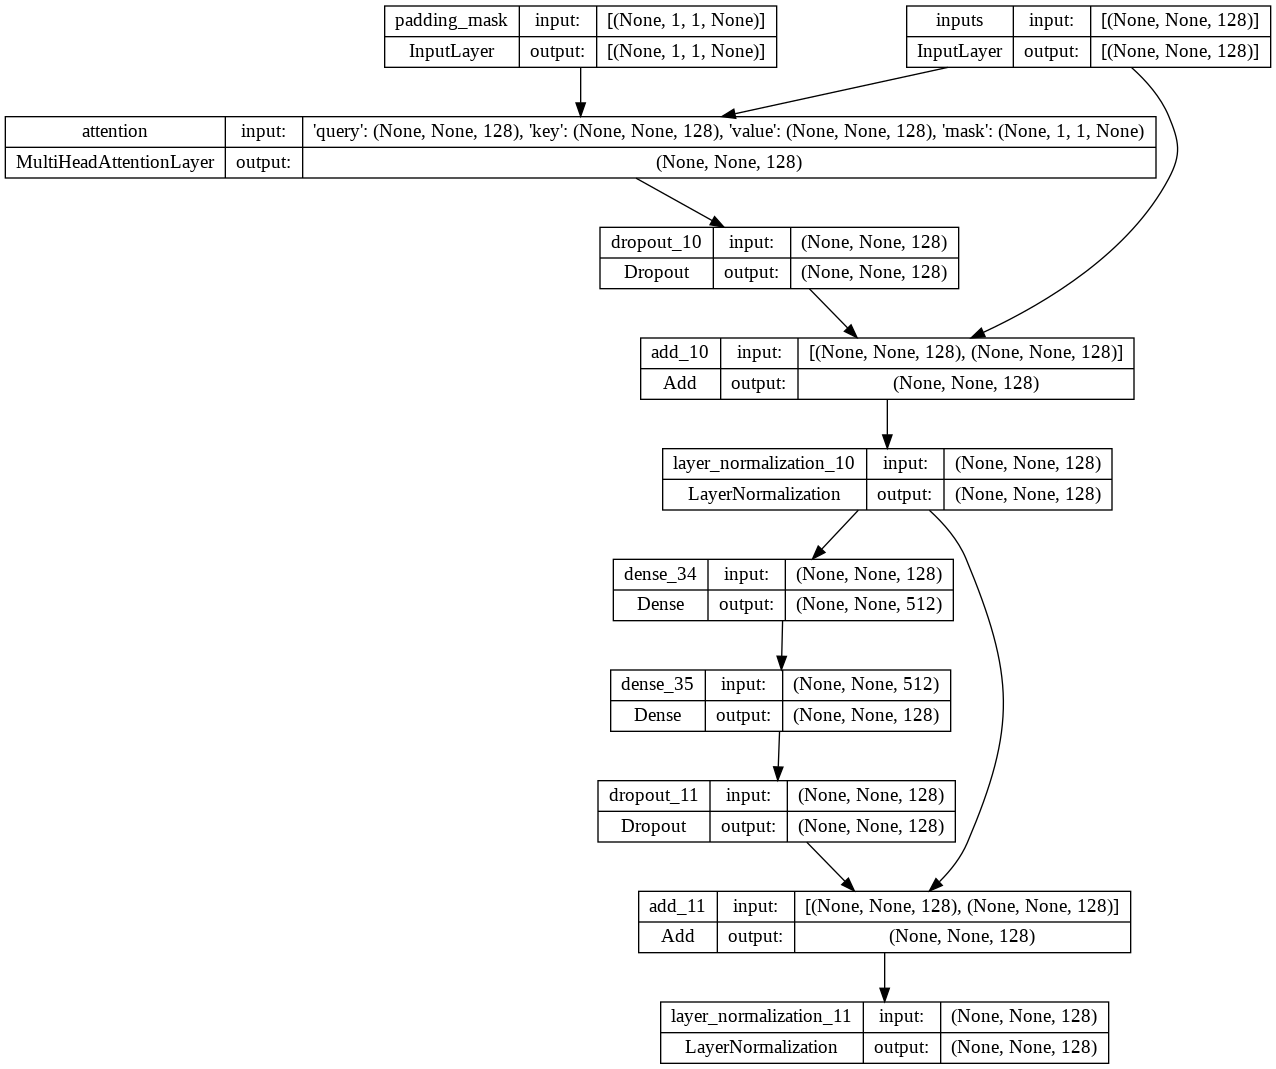

In [282]:
sample_encoder_layer = encoder_layer(
    units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_encoder_layer"
)

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file="encoder_layer.png", show_shapes=True
)

In [283]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='encoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  padding_mask = tf.keras.Input(shape=(1,1,None), name='padding_mask') #

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.keras.layers.Lambda(
      lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
  )(d_model)   #
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)  #
  
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units = units,
        d_model = d_model,
        num_heads = num_heads,
        dropout = dropout,
        name = 'encoder_layer_{}'.format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

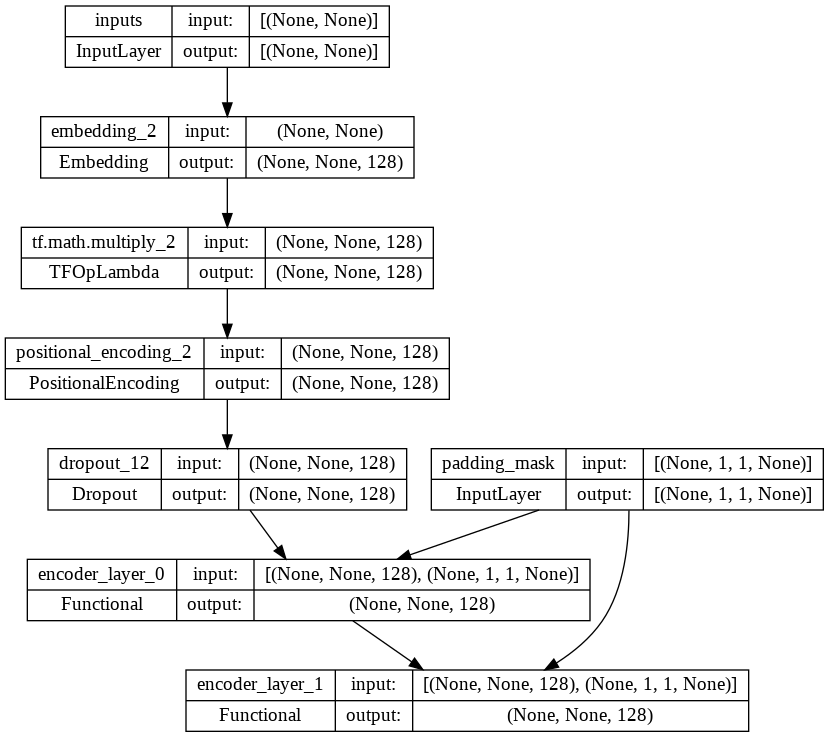

In [284]:
sample_encoder = encoder(
    vocab_size = 8192,
    num_layers = 2, 
    units = 512,
    d_model = 128,
    num_heads = 4, 
    dropout = 0.3,
    name = 'sample_encoder',
)

tf.keras.utils.plot_model(sample_encoder, to_file='encoder.png', show_shapes=True)

### Decoder Layer

In [285]:
def decoder_layer(units, d_model, num_heads, dropout, name='decoder_layer'):
  inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')  #
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')  #

  attention1 = MultiHeadAttentionLayer(d_model, num_heads, name='attention_1')(
      inputs = {
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask,
      }
  )  #
  add_attention = tf.keras.layers.add([attention1, inputs])
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  attention2 = MultiHeadAttentionLayer(d_model, num_heads, name='attention_2')(
      inputs = {
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask,
      }
  )  #

  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  add_attention = tf.keras.layers.add([attention2, attention1])
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu', name='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([outputs, attention2])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(
      inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs = outputs,
      name = name,
  )

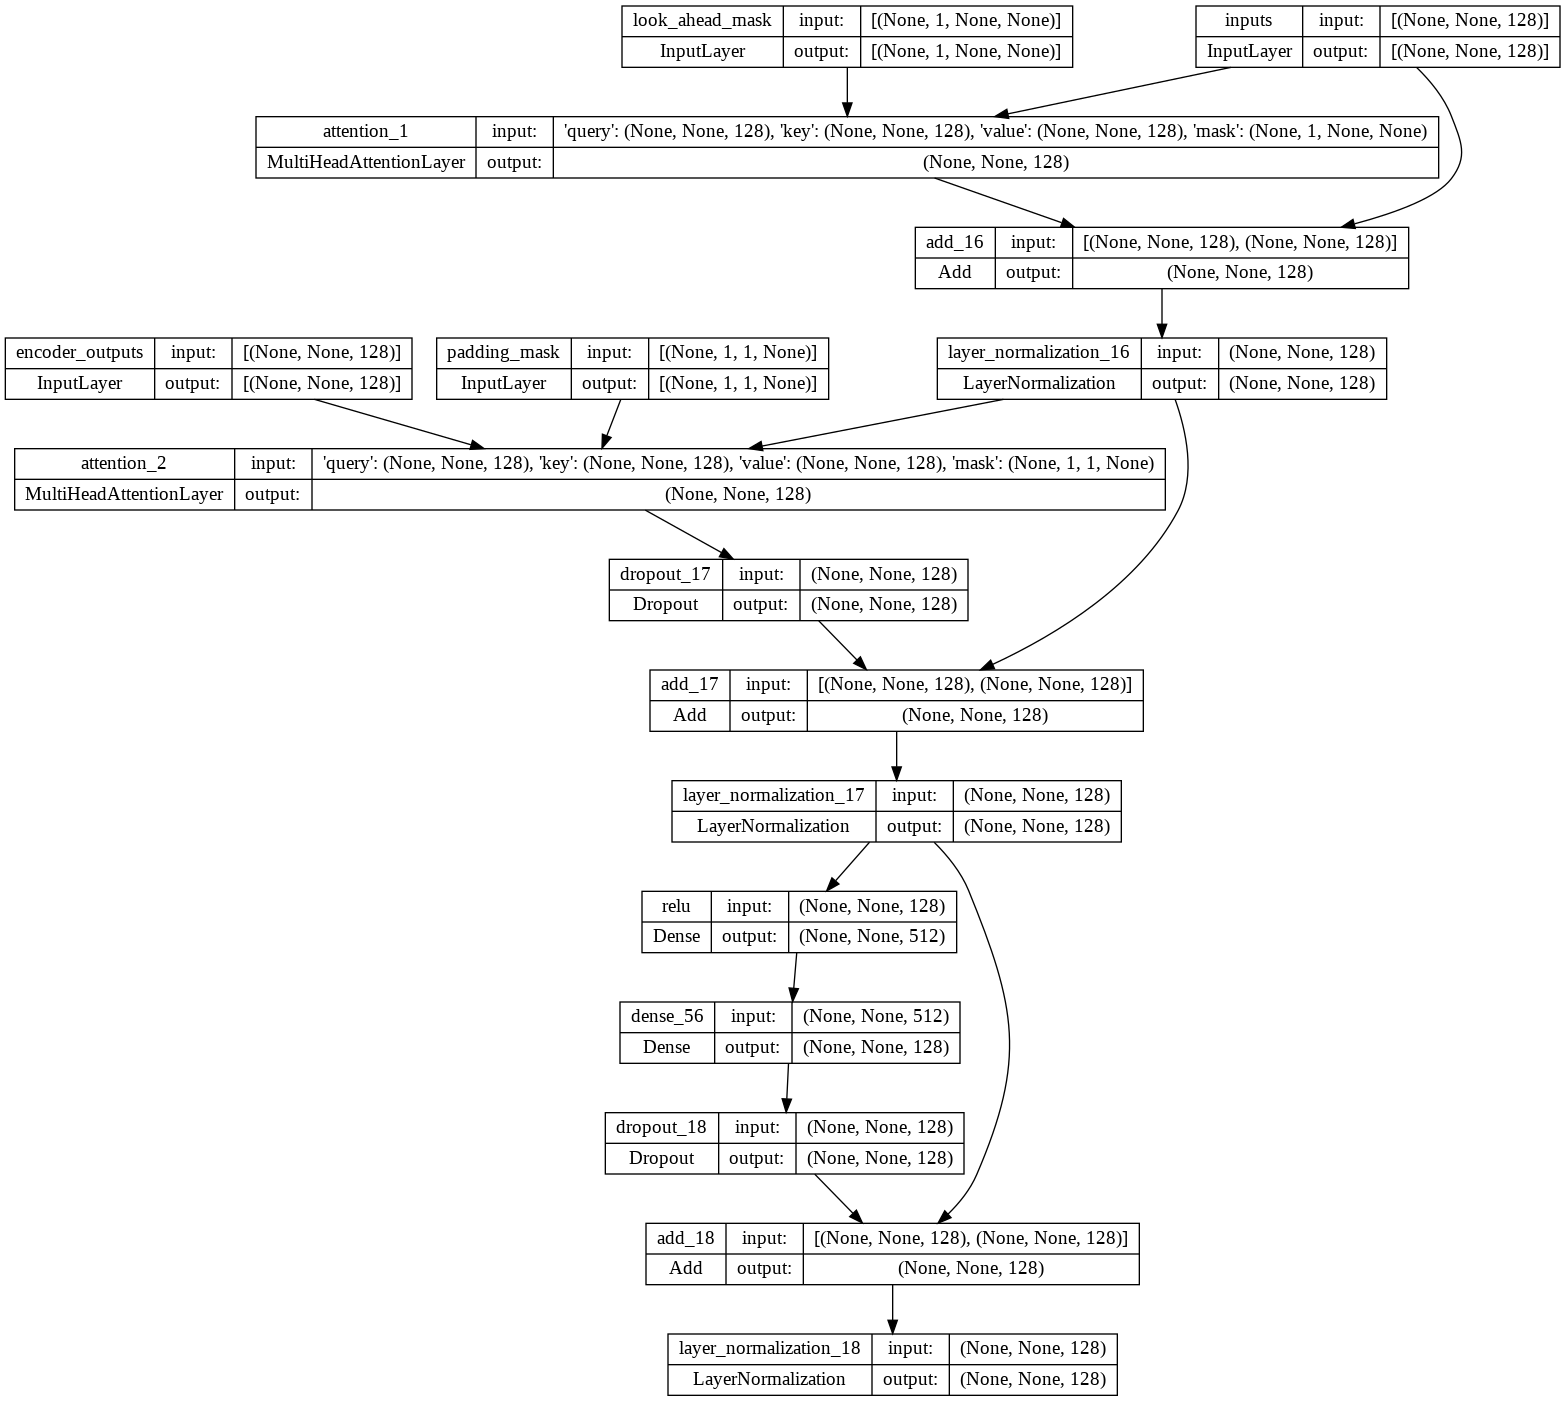

In [286]:
sample_decoder_layer = decoder_layer(
    units = 512, d_model = 128, num_heads = 4, dropout = 0.3, name = 'sample_decoder_layer'
)

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True
)

### Decoder

In [287]:
# def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
#   inputs = tf.keras.Input(shape=(None,), name='inputs')
#   enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
#   look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

#   embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
#   embeddings = tf.keras.layers.Lambda(
#       lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
#   )(d_model)
#   embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  
#   outputs = tf.keras.layer.Dropout(rate=dropout)(embeddings)
  
#   for i in range(num_layers):
#     outputs = decoder_layer(
#         units = units,
#         d_model = d_model,
#         num_heads = num_heads,
#         dropout = dropout,
#         name = 'decoder_layer_{}'.format(i),
#         )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

#   return tf.keras.Model(
#         inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
#         outputs=outputs,
#         name=name,)

In [288]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

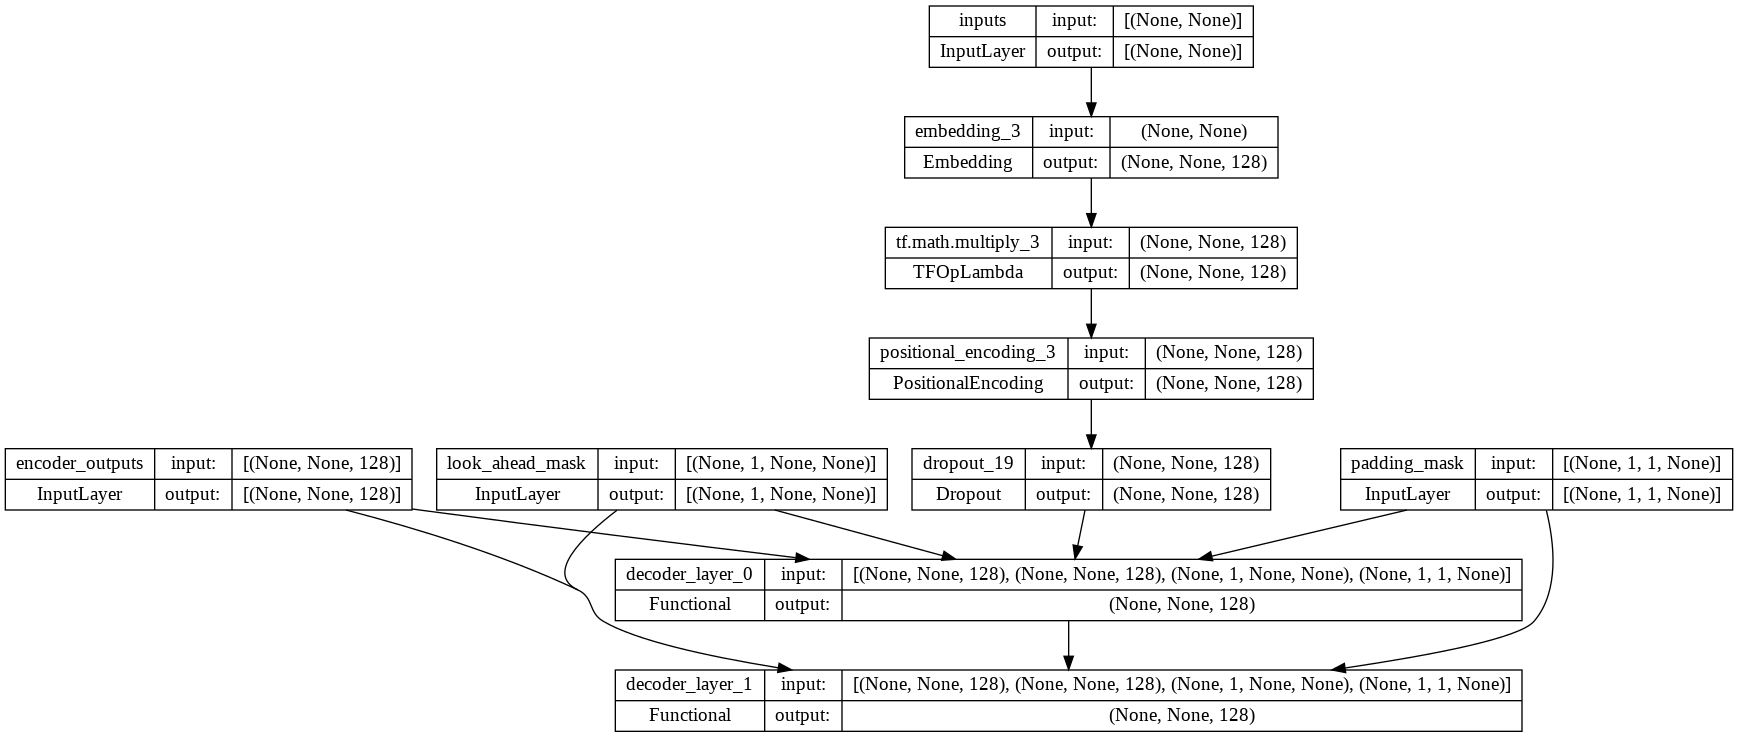

In [289]:
sample_decoder = decoder(
    vocab_size = 8192,
    num_layers = 2,
    units = 512,
    dropout = 0.3,
    num_heads = 4,
    d_model = 128,
    name = 'sample_decoder',
)

tf.keras.utils.plot_model(sample_decoder, to_file='decoder.png', show_shapes=True)

### Transformer

In [290]:
# def transformer(
#     vocab_size, num_layers, num_heads, d_model, units, dropout, name = 'transformer'
# ):
#   inputs = tf.keras.Input(shape=(None,), name='inputs') 
#   dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')  
  
#   enc_padding_mask = tf.keras.layers.Lambda(
#       create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask'
#   )(inputs)  # output_shape

#   dec_padding_mask = tf.keras.layers.Lambda(
#     create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask'
#   )(inputs)  

#   look_aheah_mask = tf.keras.layers.Lambda(
#     create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask'
#   )(dec_inputs)

#   enc_outputs = encoder(
#       vocab_size = vocab_size,
#       num_layers = num_layers,
#       num_heads = num_heads,
#       d_model = d_model,
#       units = units,
#       dropout = dropout,
#   )(inputs=[inputs, enc_padding_mask])

#   dec_outputs = decoder(
#       vocab_size = vocab_size,
#       num_layers = num_layers,
#       num_heads = num_heads,
#       d_model = d_model,
#       units = units,
#       dropout = dropout,
#   )(inputs =[dec_inputs, look_aheah_mask, enc_outputs, dec_padding_mask])

#   outputs = tf.keras.layers.Dense(units=units, dropout=dropout, name='outputs')(dec_outputs)

#   return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=[outputs], name=name)

In [291]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")   # shape  --> documentation
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

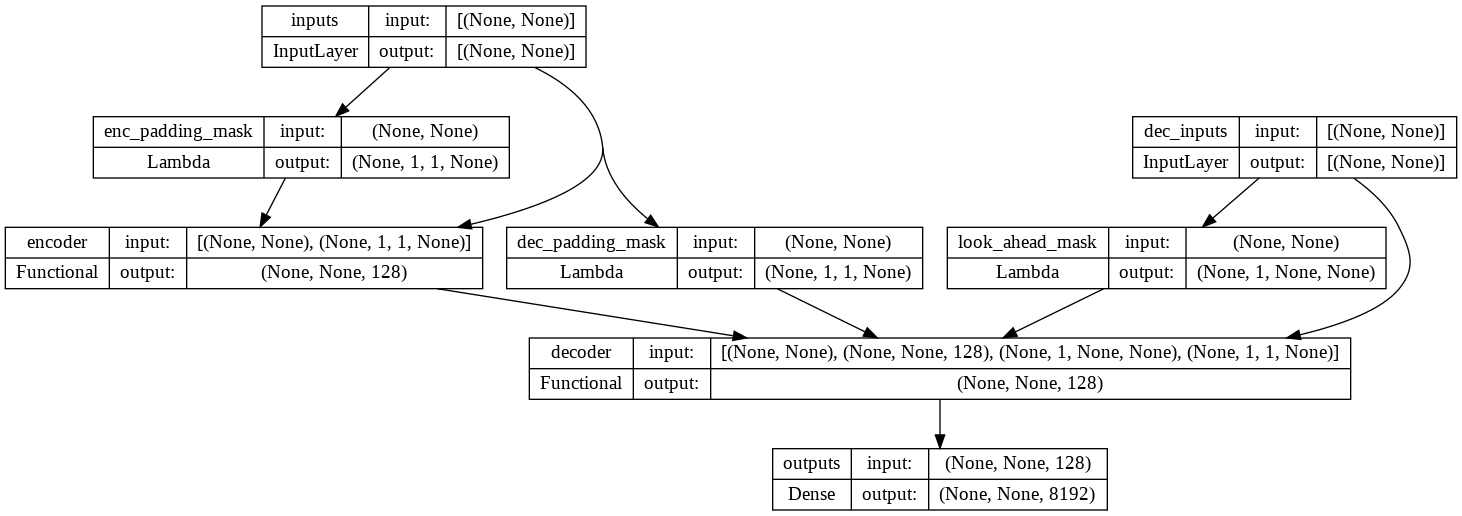

In [292]:
sample_transformer = transformer(
    vocab_size = 8192,
    num_layers = 2,
    num_heads = 4,
    d_model = 128,
    units = 512,
    dropout = 0.3,
    name = 'sample_transformer'
)

tf.keras.utils.plot_model(
    sample_transformer, to_file='tranformer.png', show_shapes=True
)

## Train model

### Loss function 

In [293]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH-1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
  )(y_true, y_pred)  #

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)  #
  loss = tf.multiply(loss, mask)
  
  return tf.reduce_mean(loss)

### Custom learning rate

In [294]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000) -> None:
     super(CustomSchedule, self).__init__()  #

     self.d_model = tf.constant(d_model, dtype=tf.float32)
     self.warmup_steps = warmup_steps

  def get_config(self):
    return {'d_model': self.d_model, 'warmup_steps': self.warmup_steps}

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)  #
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.multiply(
        tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2)
    )

Text(0.5, 0, 'Train Step')

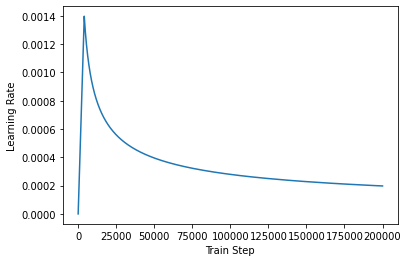

In [295]:
sample_learning_rate =  CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Initialize and compile model

In [296]:
# clear backend  
tf.keras.backend.clear_session()  #

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)  #

def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))  # -1
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model within strtegy scope
with strategy.scope():  #
  model = transformer(
      vocab_size = VOCAB_SIZE,
      num_layers = NUM_LAYERS,
      num_heads = NUM_HEADS,
      d_model = D_MODEL,
      units = UNITS,
      dropout = DROPOUT,
  )  

  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])  #

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3173632     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### Fit Model

In [ ]:
model.fit(dataset, epochs=EPOCHES)

Epoch 1/40
690/690 [==============================] - 1460s 2s/step - loss: 2.1981 - accuracy: 0.0265
Epoch 2/40
690/690 [==============================] - 1473s 2s/step - loss: 1.9037 - accuracy: 0.0316
Epoch 3/40
690/690 [==============================] - 1475s 2s/step - loss: 1.8933 - accuracy: 0.0316
Epoch 4/40
690/690 [==============================] - 1459s 2s/step - loss: 1.8835 - accuracy: 0.0319
Epoch 5/40
690/690 [==============================] - 1450s 2s/step - loss: 1.8715 - accuracy: 0.0323
Epoch 6/40
690/690 [==============================] - 1470s 2s/step - loss: 1.8569 - accuracy: 0.0330
Epoch 7/40
690/690 [==============================] - 1489s 2s/step - loss: 1.8313 - accuracy: 0.0343
Epoch 8/40
690/690 [==============================] - 1404s 2s/step - loss: 1.7917 - accuracy: 0.0361
Epoch 9/40
690/690 [==============================] - 1457s 2s/step - loss: 1.7443 - accuracy: 0.0385
Epoch 10/40
690/690 [==============================] - 1518s 2s/step - loss: 1.692

### Evaluate and Predict

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)
  
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
  )

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], trainning=False)
    # select the last word from the seq_len dimension
    predictions = predictions[:, -1, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenatd the predicted_id to the output which is given to the 
    # decoder as its input
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )
    return predicted_sentence

In [ ]:
predict('where have you been?')